In [ ]:
# import os
# import shutil

# # Dossiers source
# root_dir = "dataset/animals"
# output_dir = "dataset/animals_combined"

# # Créer le dossier de sortie
# os.makedirs(output_dir, exist_ok=True)

# # Fusionner train et validation
# for split in ["train", "val"]:
#     split_path = os.path.join(root_dir, split)
#     for class_name in os.listdir(split_path):
#         class_src = os.path.join(split_path, class_name)
#         class_dst = os.path.join(output_dir, class_name)

#         os.makedirs(class_dst, exist_ok=True)

#         for filename in os.listdir(class_src):
#             src_file = os.path.join(class_src, filename)
#             dst_file = os.path.join(class_dst, filename)
#             # Pour éviter les conflits de noms
#             if os.path.exists(dst_file):
#                 base, ext = os.path.splitext(filename)
#                 count = 1
#                 while os.path.exists(dst_file):
#                     dst_file = os.path.join(class_dst, f"{base}_{count}{ext}")
#                     count += 1
#             shutil.copy2(src_file, dst_file)

# print("Fusion terminée dans 'dataset/animals_combined'")


In [ ]:
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from torch import nn

class GaussianDiffusion:
    """Classe de diffusion gaussienne pour la génération d'images.
    Cette classe gère le processus de diffusion et de dédiffusion, y compris la génération d'échantillons à partir du modèle.
    """
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.model = model
        self.device = device
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.set_timesteps(timesteps)

    def set_timesteps(self, timesteps):
        self.timesteps = timesteps
        self.beta = torch.linspace(self.beta_start, self.beta_end, timesteps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        print(f"🔧 Diffusion mise à jour : {timesteps} étapes")

    def q_sample(self, x_start, t, noise=None):
        
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_hat = self.alpha_hat[t].sqrt().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        sqrt_one_minus_alpha_hat = (1 - self.alpha_hat[t]).sqrt().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        return sqrt_alpha_hat * x_start + sqrt_one_minus_alpha_hat * noise

    def p_sample(self, x, t, y):
        """Effectue une étape de diffusion inverse pour générer une image à partir du bruit.
        p(x_t | x_{t-1}) = N(x_{t-1}; \mu_t, \sigma_t^2 I)
        """
        # t est un tenseur de taille (batch_size,) contenant les indices de temps pour chaque échantillon
        noise_pred = self.model(x, t, y)
        beta_t = self.beta[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        alpha_t = self.alpha[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        alpha_hat_t = self.alpha_hat[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        mean = (1 / alpha_t.sqrt()) * (x - beta_t / (1 - alpha_hat_t).sqrt() * noise_pred)

        if t[0] == 0:
            return mean

        noise = torch.randn_like(x)
        sigma = beta_t.sqrt()
        return mean + sigma * noise

    def p_sample_loop(self, shape, y):
        x = torch.randn(shape).to(self.device)
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((shape[0],), t, device=self.device, dtype=torch.long)
            x = self.p_sample(x, t_tensor, y)
        return x

    def sample(self, batch_size, image_size, y):
        """
        Génère un échantillon à partir du modèle en effectuant une boucle de diffusion inverse.
        :param batch_size: Taille du lot d'échantillons à générer.
        :param image_size: Taille de l'image (hauteur, largeur).
        :param y: Étiquettes de classe pour la génération conditionnelle."""
        return self.p_sample_loop((batch_size, 3, image_size, image_size), y)





def save_sample_grid(samples, filename, nrow=4):
    samples = (samples.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    save_image(samples, filename, nrow=nrow)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """Un bloc résiduel de base pour le UNet.
    Il applique deux convolutions 2D avec une activation SiLU et ajoute un MLP pour l'embedding temporel et de classe.
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1 , padding_mode='reflect')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, padding_mode='reflect')
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.class_mlp = nn.Linear(class_emb_dim, out_channels)
        self.activation = nn.SiLU()
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t, y):
        h = self.activation(self.conv1(x))
        time_emb = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)
        class_emb = self.class_mlp(y).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb + class_emb
        h = self.conv2(self.activation(h))
        return h + self.residual_conv(x)

class DownBlock(nn.Module):
    """Un bloc de downsampling pour le UNet.
    Il applique un bloc résiduel suivi d'une convolution de downsampling.
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        self.resblock1 = ResidualBlock(in_channels, out_channels, time_emb_dim, class_emb_dim)
        self.resblock2 = ResidualBlock(out_channels, out_channels, time_emb_dim, class_emb_dim)
        self.down = nn.Conv2d(out_channels, out_channels, 4, 2, 1)  # Downsample

    def forward(self, x, t, y):
        x = self.resblock1(x, t, y)
        x = self.resblock2(x, t, y)
        return self.down(x), x

class UpBlock(nn.Module):
    """Un bloc de upsampling pour le UNet.
    Il applique une convolution de upsampling suivie de deux blocs résiduels.
    """
    def __init__(self, up_in_channels, skip_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(up_in_channels, out_channels, 4, 2, 1)
        self.resblock1 = ResidualBlock(out_channels + skip_channels, out_channels, time_emb_dim, class_emb_dim)
        self.resblock2 = ResidualBlock(out_channels, out_channels, time_emb_dim, class_emb_dim)

    def forward(self, x, skip, t, y):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock1(x, t, y)
        x = self.resblock2(x, t, y)
        return x


class UNetConditional(nn.Module):
    """Un UNet conditionnel pour la génération d'images.
    Il utilise des blocs résiduels, de downsampling et de upsampling pour traiter les images.
    """
    def __init__(self, in_channels, base_channels, time_emb_dim, class_emb_dim, num_classes):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        self.class_embed = nn.Embedding(num_classes, class_emb_dim)

        self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1, padding_mode='reflect')

        self.down1 = DownBlock(base_channels, base_channels * 2, time_emb_dim, class_emb_dim)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim, class_emb_dim)
        self.down3 = DownBlock(base_channels * 4, base_channels * 8, time_emb_dim, class_emb_dim)

        self.middle = ResidualBlock(base_channels * 8, base_channels * 8, time_emb_dim, class_emb_dim)

        
        self.up3 = UpBlock(base_channels * 8, base_channels * 8, base_channels * 4, time_emb_dim, class_emb_dim)
        self.up2 = UpBlock(base_channels * 4, base_channels * 4, base_channels * 2, time_emb_dim, class_emb_dim)
        self.up1 = UpBlock(base_channels * 2, base_channels * 2, base_channels, time_emb_dim, class_emb_dim)

        self.final_conv = nn.Conv2d(base_channels, in_channels, 1)  # pas de pooling ni réduction

    def forward(self, x, t, y):
        # print(f"[Input] x: {x.shape}")
        
        t = self.time_embed(t.unsqueeze(-1).float())
        y = self.class_embed(y)

        x = self.init_conv(x)
        # print(f"After init_conv: {x.shape}")
        
        x1, skip1 = self.down1(x, t, y)
        # print(f"After down1: {x1.shape}, skip1: {skip1.shape}")
        
        x2, skip2 = self.down2(x1, t, y)
        # print(f"After down2: {x2.shape}, skip2: {skip2.shape}")
        
        x3, skip3 = self.down3(x2, t, y)
        # print(f"After down3: {x3.shape}, skip3: {skip3.shape}")
        
        x = self.middle(x3, t, y)
        # print(f"After middle: {x.shape}")
        
        x = self.up3(x, skip3, t, y)
        # print(f"After up3: {x.shape}")
        
        x = self.up2(x, skip2, t, y)
        # print(f"After up2: {x.shape}")
        
        x = self.up1(x, skip1, t, y)
        # print(f"After up1: {x.shape}")

        out = self.final_conv(x)
        # print(f"[Output] out: {out.shape}")
        return out


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Hyperparamètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")
if device.type == "cuda":
    print(f"GPU détecté : {torch.cuda.get_device_name(0)}")
else:
    print("Pas de GPU utilisé, on est sur CPU")

epochs = 150
batch_size = 64
lr = 2e-4
image_size = 40  # Resize à 64x64
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Charger le dataset fusionné
dataset_path = "dataset/animals_combined"
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Filtrer uniquement la classe "cat"
class_names = full_dataset.classes  # ['cat', 'dog', 'elephant', 'horse', 'lion']
print(f"Classes détectées : {class_names}")
cat_class_index = class_names.index("cat")

# Filtrage
filtered_dataset = [(img, 0) for img, label in full_dataset if label == cat_class_index]

# Nombre de classes (juste cat = 0)
num_classes = 1
print(f"Nombre de classes : {num_classes} (classe 'cat' uniquement)")

# DataLoader
dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


Device utilisé : cuda
GPU détecté : NVIDIA GeForce RTX 4070 Laptop GPU
Classes détectées : ['cat', 'dog', 'elephant', 'horse', 'lion']
Nombre de classes : 1 (classe 'cat' uniquement)


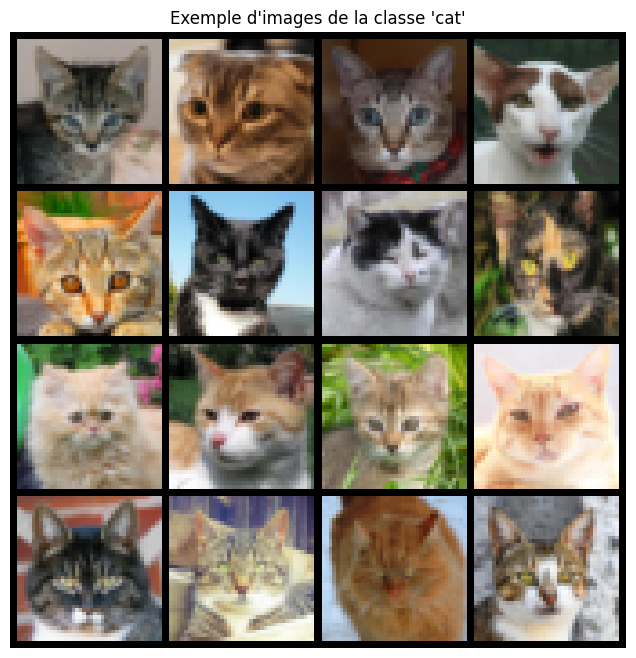

In [29]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Obtenir un batch d'images
images, labels = next(iter(dataloader))

# Dénormaliser (passer de [-1, 1] à [0, 1])
images = (images * 0.5) + 0.5

# Créer une grille d'images
grid = vutils.make_grid(images[:16], nrow=4)

# Affichage
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title("Exemple d'images de la classe 'cat'")
plt.show()


In [1]:
from tqdm.notebook import tqdm
import torch.nn.utils

# Modèle et diffusion
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=num_classes).to(device)
diffusion = GaussianDiffusion(model, timesteps=100, beta_end=0.02, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
timestep_increment = 100
timestep_schedule_every = 10
max_timesteps = 1000
current_max_sample_t = diffusion.timesteps

for epoch in range(1, epochs + 1):
    model.train()
    epoch_losses = []

    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs} | Timesteps: {diffusion.timesteps} | Sample t ∈ [0,{current_max_sample_t})")
    
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, min(current_max_sample_t, diffusion.timesteps - 2), (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)

        noise_pred = model(x_t, t, y)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 🛡️ stabilise l'explosion
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch} terminé — Moyenne loss : {avg_loss:.4f}")

    # Mise à jour des timesteps toutes les 10 epochs
    if epoch % timestep_schedule_every == 0 and diffusion.timesteps < max_timesteps:
        new_steps = min(diffusion.timesteps + timestep_increment, max_timesteps)
        diffusion.set_timesteps(new_steps)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f"Optimiseur réinitialisé après update des timesteps à {new_steps}")

    # Planning t max progressif (évite de taper T-1 trop tôt)
    dizaine = epoch // 10
    position = epoch % 10

    if epoch <= 10:
        current_max_sample_t = 100
    elif epoch >= 100:
        current_max_sample_t = 999
    else:
        if position == 0:
            current_max_sample_t = dizaine * 100
        elif position == 1:
            current_max_sample_t = dizaine * 100 + 25
        elif position == 2:
            current_max_sample_t = dizaine * 100 + 50
        elif position == 3:
            current_max_sample_t = dizaine * 100 + 75
        elif position == 4:
            current_max_sample_t = dizaine * 100 + 85
        elif position == 5:
            current_max_sample_t = dizaine * 100 + 95
        elif position == 6:
            current_max_sample_t = dizaine * 100 + 98
        elif position in [7, 8, 9]:
            current_max_sample_t = dizaine * 100 + 99

        current_max_sample_t = min(current_max_sample_t, diffusion.timesteps - 1)

    # Échantillonnage
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            y_sample = torch.tensor([0] * 16, device=device)
            samples = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
            save_sample_grid(samples, os.path.join(save_dir, f"sample_epoch_{epoch}.png"), nrow=4)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch}.pt"))
            print(f"Échantillons + modèle sauvegardés (epoch {epoch}) dans {save_dir}")


KeyboardInterrupt: 

Cellule au dessus fonctionnelle, je l'ai juste relancé par erreur

C:\Users\mbell\AppData\Local\Temp\ipykernel_21220\3133666572.py:32: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mbell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


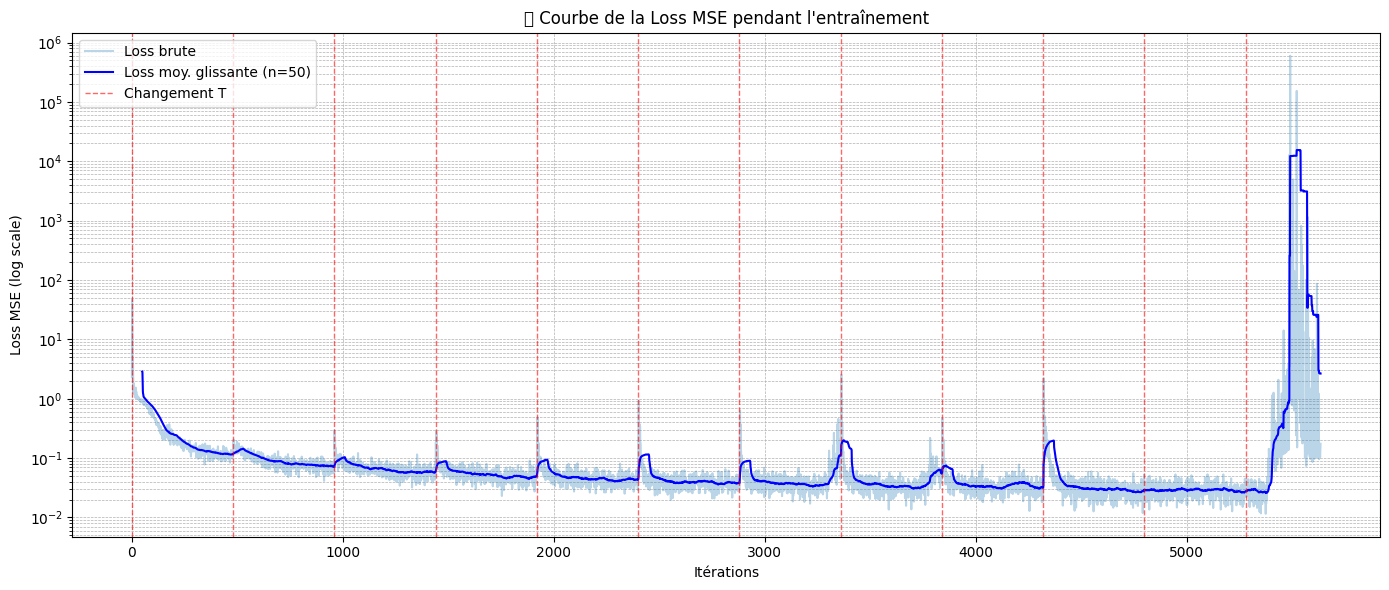

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

# Paramètres
window = 50  # Moyenne glissante
iterations_per_epoch = len(dataloader)  # nombre d'itérations pour 1 epoch

# Moyenne glissante
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')

# Courbes
plt.plot(losses, alpha=0.3, label="Loss brute")
plt.plot(range(window - 1, len(losses)), smoothed, color='blue', label=f"Loss moy. glissante (n={window})")

# Échelle log pour la lisibilité
plt.yscale("log")

# Lignes verticales aux changements de T (epochs multiples de 10)
max_epoch = len(losses) // iterations_per_epoch
for e in range(0, max_epoch + 1, 10):
    x = e * iterations_per_epoch
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1, alpha=0.6, label='Changement T' if e == 0 else None)

# Légendes & axes
plt.xlabel("Itérations")
plt.ylabel("Loss MSE (log scale)")
plt.title("Courbe de la Loss MSE pendant l'entraînement")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


✅ Modèle chargé depuis results_chats/model_epoch_110.pt
🔧 Diffusion mise à jour : 1000 étapes


C:\Users\mbell\AppData\Local\Temp\ipykernel_21220\1115857619.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


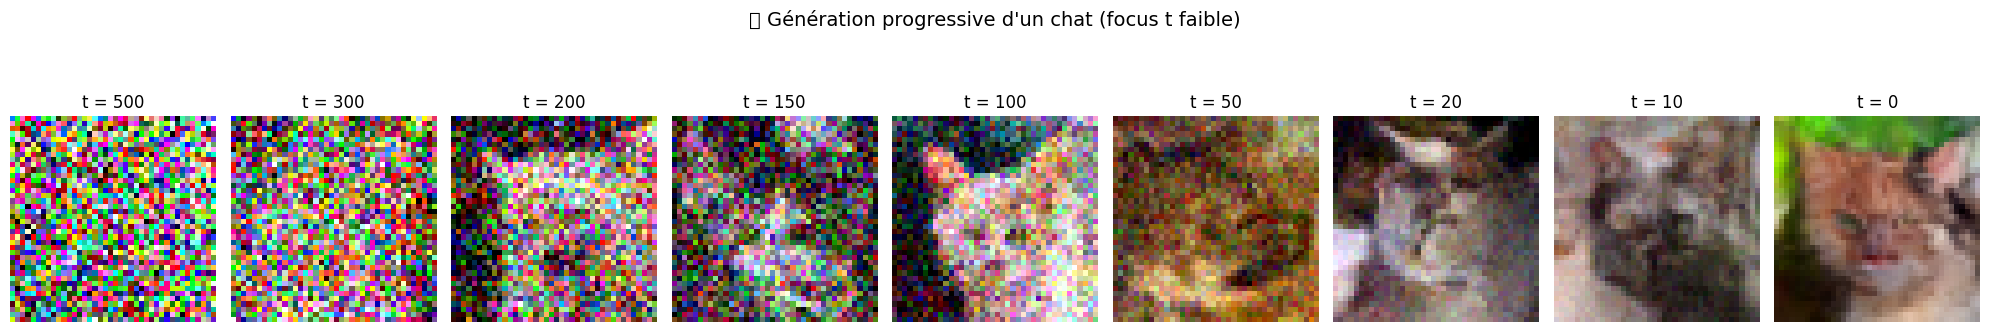

In [ ]:
import torch
import matplotlib.pyplot as plt

# Charger le modèle entraîné ( change les paramètres si différents)
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=1).to(device)
model.load_state_dict(torch.load("results_chats/model_epoch_110.pt", map_location=device))
model.eval()
print(" Modèle chargé depuis results_chats/model_epoch_110.pt")

# Recréer la diffusion avec le bon modèle et T=1000
diffusion = GaussianDiffusion(model, timesteps=1000, device=device)

# Étapes t faibles à visualiser
t_steps = [500, 300, 200, 150, 100, 50, 20, 10, 0]
y_class = torch.tensor([0], device=device)  # Classe unique
x = torch.randn(1, 3, 40, 40).to(device)

fig, axs = plt.subplots(1, len(t_steps), figsize=(20, 4))

# Génération partielle jusqu’à t
def partial_sample_loop(diffusion, x_start, y, t_start):
    x = x_start.clone()
    with torch.no_grad():
        for t in reversed(range(t_start, diffusion.timesteps)):
            t_tensor = torch.full((x.size(0),), t, device=diffusion.device, dtype=torch.long)
            x = diffusion.p_sample(x, t_tensor, y)
    return x

#  Boucle de génération
with torch.no_grad():
    for i, target_t in enumerate(t_steps):
        x_t = partial_sample_loop(diffusion, x, y_class, target_t)

        img = (x_t.squeeze().clamp(-1, 1) + 1) / 2
        img = img.permute(1, 2, 0).cpu().numpy()

        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(f"t = {target_t}")

plt.suptitle(" Génération progressive d'un chat (focus t faible)", fontsize=14)
plt.tight_layout()
plt.show()


✅ Modèle chargé depuis results_chats/model_epoch_110.pt
🔧 Diffusion mise à jour : 1000 étapes


C:\Users\mbell\AppData\Local\Temp\ipykernel_21220\1631639533.py:41: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mbell\AppData\Local\Temp\ipykernel_21220\1631639533.py:41: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mbell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mbell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


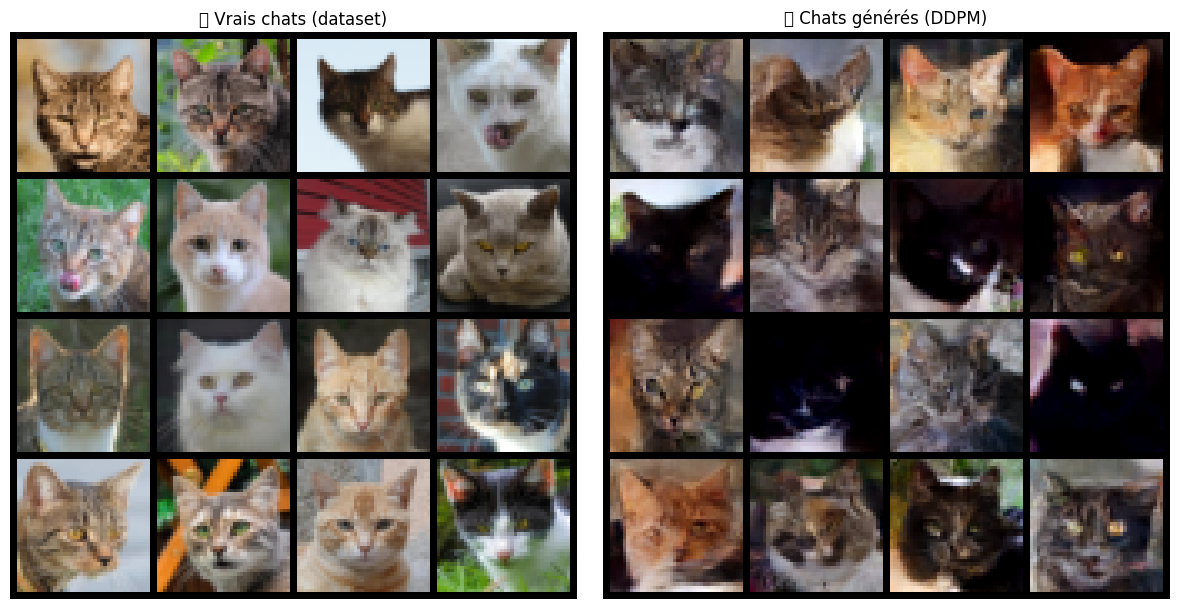

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision

# Charger le modèle chats
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=1).to(device)
model.load_state_dict(torch.load("results_chats/model_epoch_110.pt", map_location=device))
model.eval()
print("Modèle chargé depuis results_chats/model_epoch_110.pt")

# Recréer la diffusion avec T=1000
diffusion = GaussianDiffusion(model, timesteps=1000, device=device)

# 1. Batch d’images réelles
real_images, real_labels = next(iter(dataloader))
real_images = (real_images * 0.5) + 0.5  # dé-normalisation [-1,1] → [0,1]
real_grid = torchvision.utils.make_grid(real_images[:16], nrow=4)

# 2. Générer un batch de chats synthétiques
with torch.no_grad():
    y_sample = torch.zeros(16, dtype=torch.long, device=device)  # tous label 0 = chat
    fake_images = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
    fake_images = (fake_images.clamp(-1, 1) + 1) / 2
    fake_grid = torchvision.utils.make_grid(fake_images, nrow=4)

# 3. Affichage comparatif
plt.figure(figsize=(12, 6))

# Vrais
plt.subplot(1, 2, 1)
plt.imshow(real_grid.permute(1, 2, 0).cpu().numpy())
plt.title("Vrais chats (dataset)")
plt.axis("off")

# Générés
plt.subplot(1, 2, 2)
plt.imshow(fake_grid.permute(1, 2, 0).cpu().numpy())
plt.title("Chats générés (DDPM)")
plt.axis("off")

plt.tight_layout()
plt.show()


🔧 Diffusion mise à jour : 1000 étapes


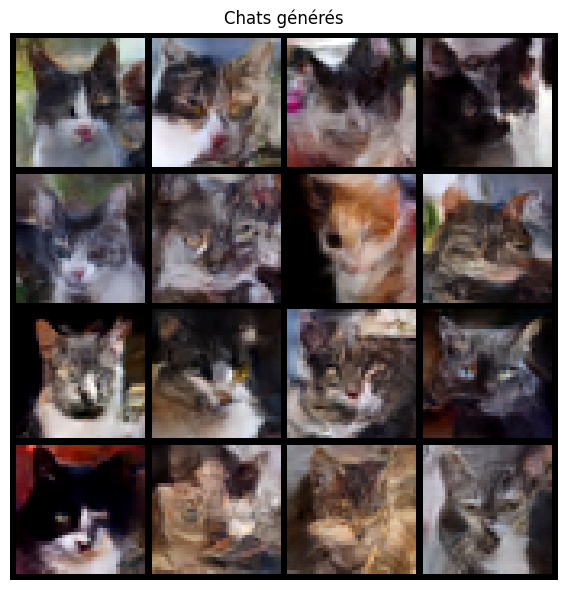

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision

# Charger le modèle
model = UNetConditional(in_channels=3, base_channels=64, time_emb_dim=256, class_emb_dim=128, num_classes=1).to(device)
model.load_state_dict(torch.load("results_chats/model_epoch_110.pt", map_location=device))
model.eval()

# Recréer la diffusion
diffusion = GaussianDiffusion(model, timesteps=1000, device=device)

# Génération de 16 chats
with torch.no_grad():
    y_sample = torch.zeros(16, dtype=torch.long, device=device)
    fake_images = diffusion.sample(batch_size=16, image_size=image_size, y=y_sample)
    fake_images = (fake_images.clamp(-1, 1) + 1) / 2
    fake_grid = torchvision.utils.make_grid(fake_images, nrow=4)

# Affichage
plt.figure(figsize=(6, 6))
plt.imshow(fake_grid.permute(1, 2, 0).cpu().numpy())
plt.title("Chats générés")
plt.axis("off")
plt.tight_layout()
plt.show()
